## Notice

Paper: ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762)

해당 튜토리얼은 논문을 보다 쉽게 이해하고, 그 내용을 직접 코드로 구현하여 실행해볼 수 있도록 하는 것을 목표로 하고 있습니다. 코드 구현은 논문의 서술된 순서를 따라 진행되었으며, 영어로 작성된 부분은 논문 내용을 발췌한 것입니다.

#### Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

##### Google Colab Setup
we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'for_knn.py', 'linear_classifier.py', 'word_classification.py', 'word2vec.py', 'custom_model_utils', 'Convolutional_Neural_Network', '_modules.py', '_utils.py', 'save.py', '_word_processing.py', '_layers.py', 'enc2dec', 'data', '_data.py', 'test.py', 'bert_utils.py', 'models', 'colab_utils']


##### NLP Setup Codes

In [4]:
!pip install 'portalocker>=2.0.0'

In [5]:
import torch
import torchtext
import torchdata

print(f'torch version: {torch.__version__}')
print(f'torchtext version: {torchtext.__version__}')
print(f'torchtext data: {torchdata.__version__}')

torch version: 2.2.1+cu121
torchtext version: 0.17.1+cpu
torchtext data: 0.7.1


## Multi30k Datasets

In [6]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 57.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
from torch.utils.data import DataLoader

# custom packages
from data.multi30k import load_Multi30k, build_Multi30k_vocab, Multi30kCollate
from data.word_processing import build_transform

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
train_datasets, val_datasets = load_Multi30k(root='.')
tokenizer, vocab, ln_idx = build_Multi30k_vocab(train_datasets, min_freq=2)


collate_fn = Multi30kCollate(src_transform=build_transform(tokenizer['de'], vocab['de']),
                             tgt_transform=build_transform(tokenizer['en'], vocab['en']),
                             PAD_IDX=vocab['en'].stoi['<pad>'],
                             batch_first=True)


data_loaders = {}
data_loaders['train'] = DataLoader(train_datasets, batch_size=128, collate_fn=collate_fn, shuffle=True)
data_loaders['val'] = DataLoader(val_datasets, batch_size=128, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Transformer

Transformer는 Encoder와 Decoder로 구성되어 있으며, Encoder는 총 6개의 레이어를 가지며, 각 레이어는 두 개의 서브 레이어를 가지고 있다. Decoder도 마찬가지로 총 6개의 레이어가 쌓여있는 구조이지만, Encoder와 달리, 각 레이어는 세 개의 서브 레이어를 가지고 있다


#### Encoder
- Multi-Head Self-Attention Layer
  - 입력 시퀀스의 각 원소가 다른 원소에 얼마나 의존하는지를 계산한다.
- Feed-Forward Neural Network Layer
  - 이전 서브 레이어의 출력을 받아들여 각 원소에 대한 새로운 표현을 계산한다.

#### Decoder
- Masked Multi-Head Attention Layer
  - 입력 시퀀스의 각 위치에 대해 현재 위치 이전의 모든 위치에 대한 정보만을 참조하도록 마스킹된 어텐션을 수행한다.
- Multi-Head Attention Layer
  - Encoder의 출력과 이전 Decoder 층의 출력을 이용하여 인코더-디코더 어텐션을 수행한다.
- Feed-Forward Neural Network Layer
  - 이전의 어텐션 계층들의 출력을 입력으로 받아 각 위치에서 토큰의 다음 값을 예측한다.

## 3. Model Architecture

The Transformer follows endoder-decoder structure using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Transformer(nn.Module):
  def __init__(self, d_model=512,
               dim_feedforward=2048,
               num_encoder_layers=6,
               num_decoder_layers=6,
               nhead=8,
               dropout=0.1):
      super().__init__()

      self.encoder = Encoder(d_model, dim_feedforward, num_encoder_layers, nhead, dropout)
      self.decoder = Decoder(d_model, dim_feedforward, num_decoder_layers, nhead, dropout)

  def forward(self, src_embed, tgt_embed, tgt_mask=None,
              src_pad_mask=None):

      enc_out = self.encoder(src_embed, src_pad_mask)
      output = self.decoder(tgt_embed, enc_out, tgt_mask)
      return output

## 3.1 Encoder and Decoder Stacks



### Encoder

The encoder is composed of a stack of $N=6$ identical layers. Each layer has two sub-layers. The first is a **multi-head self-attention** mechanism, and the second is a simple, **position-wise fully connected feed-forward** network. We employ a residual connection around each of the two sub-layers, followed by layer normalization. To facilitate thse residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model}=512$.



In [11]:
class ResidualLayer(nn.Module):
  def __init__(self, d_model=512, dropout=0.1):
      super().__init__()

      self.norm = nn.LayerNorm(d_model)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x, prev_x):
      x = self.dropout(x)
      out = self.norm(x + prev_x)
      return out

In [12]:
class Encoder(nn.Module):
  def __init__(self, d_model=512,
               dim_feedforward=2048,
               num_encoder_layers=6,
               nhead=8,
               dropout=0.1):
      super().__init__()

      self.encoder_layers = nn.ModuleList([
          EncoderLayer(d_model, dim_feedforward,nhead, dropout) for _ in range(num_encoder_layers)])

  def forward(self, src, src_pad_mask=None):
      for _layer in self.encoder_layers:
          src = _layer(src, src_pad_mask)

      return src

In [13]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model=512,
               dim_feedforward=2048,
               nhead=8,
               dropout=0.1):
      super().__init__()

      # first sub-layer
      self.multi_head_attn = MultiHeadAttention(d_model, nhead)
      self.residule1 = ResidualLayer(d_model, dropout)

      # second sub-layer
      self.position_wise_ff = PositionWiseFFN(d_model, dim_feedforward)
      self.residule2 = ResidualLayer(d_model, dropout)

  def forward(self, src, src_pad_mask=None):

      attn = self.multi_head_attn(src, src, src, src_pad_mask)
      out = self.residule1(attn, src)

      ff = self.position_wise_ff(out)
      out = self.residule2(ff, out)

      return out

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder. we employ residual connections around each of the sub-layers, followed by layer normalization. We also **modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent postions.** This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the knwn outputs at positions less then $i$.



In [14]:
class Decoder(nn.Module):
  def __init__(self, d_model=512,
               dim_feedforward=2048,
               num_decoder_layers=6,
               nhead=8,
               dropout=0.1):
      super().__init__()

      self.decoder_layers = nn.ModuleList([
          DecoderLayer(d_model, dim_feedforward, nhead, dropout) for _ in range(num_decoder_layers)])

  def forward(self, tgt, enc_out, tgt_mask=None):
      for _layer in self.decoder_layers:
          tgt = _layer(tgt, enc_out, tgt_mask)

      return tgt

In [15]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model=512,
               dim_feedforward=2048,
               nhead=8,
               dropout=0.1):
      super().__init__()

      # first sub-layer
      self.mask_multi_head_attn = MultiHeadAttention(d_model, nhead)
      self.residule1 = ResidualLayer(d_model, dropout)

      # second sub-layer
      self.cross_multi_head_attn = MultiHeadAttention(d_model, nhead)
      self.residule2 = ResidualLayer(d_model, dropout)

      # third sub-layer
      self.position_wise_ff = PositionWiseFFN(d_model, dim_feedforward)
      self.residule3 = ResidualLayer(d_model, dropout)


  def forward(self, tgt, enc_out, tgt_mask=None):

      mask_attn = self.mask_multi_head_attn(tgt, tgt, tgt, tgt_mask)
      out = self.residule1(mask_attn, tgt)

      attn = self.cross_multi_head_attn(out, enc_out, enc_out)
      out = self.residule2(attn, out)

      ff = self.position_wise_ff(out)
      out = self.residule3(ff, out)

      return out

## 3.2.1 Scaled Dot-Product Attention



The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:

$$\text{Attention}(Q, K, V)=\text{softmax}(\frac{OK^T}{\sqrt{d_k}})V$$

## 3.2.2 Multi-Head Attention

We found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k, d_k$ and $d_v$ dimentions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values.

Where the projections are parameter matrices $W_i^Q\in\mathbb{R}^{d_{model}\times d_k}, W_i^K\in\mathbb{R}^{d_{model}\times d_k}, W_i^V\in\mathbb{R}^{d_{model}\times d_v}$ and $W^O\in\mathbb{R}^{hd_v\times d_{model}}$.

In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{model}/h=64$. Due to the reduced dimension of each head, the total computational cost is similare to that of single-head attention with full dimensionality.





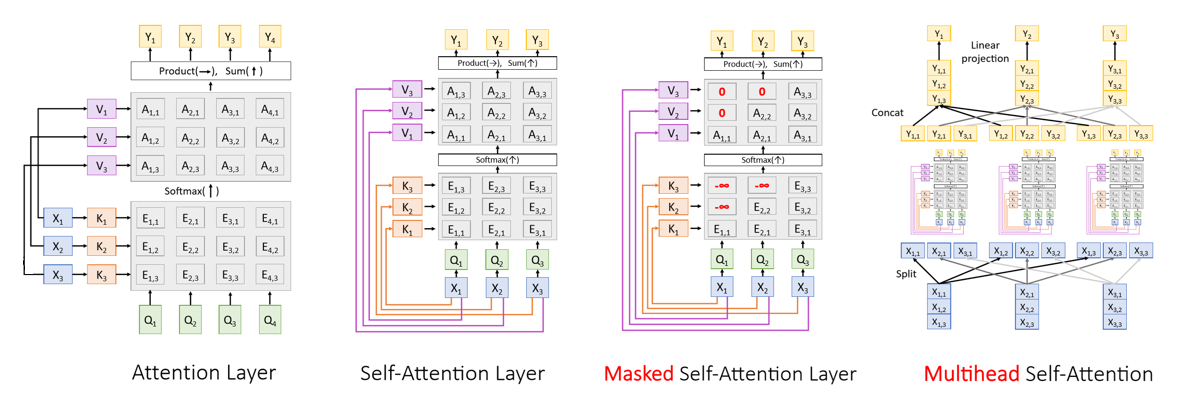

위의 그림이 Attention Layer에 대해 자세히 묘사하고있다. [출처: EECS498 강의]

- Scaled Dot Product
  - Scaled Dot Product는 Attention 메커니즘의 한 종류로, 쿼리(Query)와 키(Key)의 유사도를 계산한 후 이를 확률로 변환하여 얻는다. 이렇게 얻은 확률은 주어진 입력에 대한 각 키(Key)의 중요도를 나타내는데, 이를 attention weight라고 한다. 이후 이 attention weight를 가중치로 사용하여 값(Value)에 반영한다. 즉,  유사도가 높은 키(Key)에 해당하는 값(Value)들이 더 큰 가중치를 받아 전체적으로 더 많은 Attention을 받게 된다.
- Attention
  - Attention은 쿼리(Query), 키(Key), 값(Value)의 세 가지 벡터를 입력으로 받는다. 이때 키(Key)와 값(Value)을 가중치 행렬($W$)을 통해 변형시키고,이를 이용하여 쿼리(Query)와의 유사도를 계산한다.
- Self-Attention
  - Self-Attention은 입력 시퀀스 내의 각 요소가 서로에게 주는 관심의 정도를 계산한다. 즉, 쿼리(Query), 키(Key), 값(Value)를 모두 동일한 입력으로 사용하여 자기 자신을 포함한 모든 다른 요소들에 대해 각각의 요소가 얼마나 주목해야 하는지를 결정한다.
- Masked Self-Attention
  - Masked Self-Attention은 Transformer Decoder에서 이전에 생성한 토큰들을 기반으로 다음에 올 토큰을 생성할 때 사용된다. 이때 다음 토큰을 예측할 때 자기 자신 이후의 토큰에 대한 정보를 참고할 수 없도록 하삼각 마스크를 사용하여 attention weight를 마스킹해 현재 위치 이전의 정보만을 사용하여 다음 토큰을 예측할 수 있게 한다.
- Multihead Self-Attention
  -  Multihead Self-Attention은 Self-Attention을 head개의 병렬로 확장시킨 것이다. 각각은 서로 다른 특징을 학습할 수 있도록 다른 가중치 행렬을 사용하며, 이를 통해 모델이 여러 가지 측면에서 입력에 Attention할 수 있게된다.


> In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-tosequence models.

> The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

> Self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out all values in the input of the softmax wich correspond to illegal connections.

In [16]:
def scaled_dot_product(Q, K, V, mask=None):
    energy = torch.matmul(Q, K.transpose(3,2)) / K.size(-1) ** 0.5

    if mask is not None:
       energy = energy.masked_fill(mask==0, -float('inf'))

    attn_weight = F.softmax(energy, dim=-1)
    return torch.matmul(attn_weight, V), attn_weight

In [17]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model=512, nhead=8):
      super().__init__()
      assert d_model % nhead == 0

      self.nhead = nhead
      self.d_k = d_model // nhead

      self.fc_q = nn.Linear(d_model, d_model)
      self.fc_k = nn.Linear(d_model, d_model)
      self.fc_v = nn.Linear(d_model, d_model)

      self.fc = nn.Linear(d_model, d_model)

  def forward(self, query, key, value, mask=None):
      N = query.size(0)

      Q = self.fc_q(query).view(N, -1, self.nhead, self.d_k).transpose(2,1)
      K = self.fc_k(key).view(N, -1, self.nhead, self.d_k).transpose(2,1)
      V = self.fc_v(value).view(N, -1, self.nhead, self.d_k).transpose(2,1)

      attn, _ = scaled_dot_product(Q, K, V, mask=mask)
      attn = attn.transpose(2,1).contiguous().view(N, -1, self.nhead * self.d_k)
      output = self.fc(attn)
      return output

## 3.3 Position-wise Feed-Forward Networks

Each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

The dimensionality of input and output is $d_{model}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [18]:
class PositionWiseFFN(nn.Module):
  def __init__(self, d_model=512, dim_feedforward=2048):
      super().__init__()

      self.fc1 = nn.Linear(d_model, dim_feedforward)
      self.fc2 = nn.Linear(dim_feedforward, d_model)

  def forward(self, x):

      out = self.fc1(x)
      out = F.relu(out)
      out = self.fc2(out)
      return out

## 3.4 Embeddings and Softmax

In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [24]. In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

## 3.5 Positional Encoding

> Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.

We add "positional encodings" to the input embeddings at the bottoms of the encoder adn decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddigns, so that the two can be summed. There are many choices of positional encodings, learned and fixed.

In this work, we use sine and cosine functions of different frequencies:

$$\begin{align}PE(pos, 2i)=sin(pos/10000^{2i/d_{model}})\\
PE(pos, 2i+1)=cos(pos/10000^{2i/d_{model}})\end{align}$$

where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

We also experimented with using learned positional embeddings [8] instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

In [19]:
def get_positional_encoding(d_model, max_len=5000):

    positional_encoding = torch.zeros((max_len, d_model))

    div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
    pos = torch.arange(0, max_len).unsqueeze(1)

    positional_encoding[:, 0::2] = torch.sin(pos * div_term)
    positional_encoding[:, 1::2] = torch.cos(pos * div_term)

    positional_encoding = positional_encoding.unsqueeze(0)
    return positional_encoding

In [20]:
class TokenEmbeding(nn.Module):
  def __init__(self,vocab_size, d_model=512, dropout=0.1):
      super().__init__()

      self.d_model = d_model
      self.dropout = nn.Dropout(dropout)
      self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x, positional_encoding):
      embed = self.embedding(x) * (self.d_model ** 0.5)
      embed = embed + positional_encoding[:,:embed.size(1), :]
      embed = self.dropout(embed)

      return embed

## Train Model

In [21]:
def get_subsequent_mask(seq_length):
    return torch.tril(torch.ones(seq_length, seq_length))

In [22]:
def get_pad_mask(x):
    return (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

In [23]:
class TransformerMachineTranslation(nn.Module):
  def __init__(self,src_vocab_size,
               tgt_vocab_size,
               d_model=512,
               dim_feedforward=2048,
               num_encoder_layers=6,
               num_decoder_layers=6,
               nhead=8,
               dropout=0.1,
               device='cuda'):

      super().__init__()

      self.d_model = d_model
      self.device = device

      self.src_embedding = TokenEmbeding(src_vocab_size, d_model, dropout)
      self.tgt_embedding = TokenEmbeding(tgt_vocab_size, d_model, dropout)
      self.positional_encoding = get_positional_encoding(max_len=5000, d_model=d_model).to(device)
      self.positional_encoding.requires_grad = False

      self.transformer = Transformer(d_model, dim_feedforward,
                                     num_encoder_layers, num_decoder_layers,
                                     nhead, dropout)

      self.fc = nn.Linear(d_model, tgt_vocab_size)
      self._init_weight()

  def _init_weight(self):
      nn.init.normal_(self.src_embedding.embedding.weight, mean=0., std=self.d_model ** -0.5)
      self.tgt_embedding.embedding.weight = self.src_embedding.embedding.weight

  def forward(self, src, tgt):

      src_pad_mask = get_pad_mask(src)
      tgt_mask = get_subsequent_mask(tgt.size(-1)).to(self.device)

      src_embed = self.src_embedding(src, self.positional_encoding)
      tgt_embed = self.tgt_embedding(tgt, self.positional_encoding)

      output = self.transformer(src_embed, tgt_embed,
                                tgt_mask, src_pad_mask)
      output = self.fc(output)

      return output

  def encoder(self,src):
      src_embed = self.src_embedding(src, self.positional_encoding)
      return self.transformer.encoder(src_embed)

  def decoder(self, tgt, enc_out):
      tgt_embed = self.tgt_embedding(tgt, self.positional_encoding)
      mask = get_subsequent_mask(tgt_embed.size(1)).to(self.device)
      return self.transformer.decoder(tgt_embed, enc_out, mask)

# Sanity Check

In [24]:
num_train = len(train_datasets)
num_val = len(val_datasets)

print(f"number of train : {num_train}")
print(f"number of val : {num_val}")
print(f'\nsize of src vocab : {len(vocab["de"])}')
print(f'size of tgt vocab : {len(vocab["en"])}')

number of train : 29001
number of val : 1015

size of src vocab : 7853
size of tgt vocab : 5893


In [25]:
import torch.optim as optim

# custom package
import colab_utils.transformer as utils

In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = TransformerMachineTranslation(src_vocab_size=len(vocab['de']),
                                      tgt_vocab_size=len(vocab['en']),
                                      d_model=512,
                                      dim_feedforward=2048,
                                      num_encoder_layers=6,
                                      num_decoder_layers=6,
                                      nhead=8,
                                      dropout=0.1,
                                      device=device)


model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab['en'].stoi['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

src, tgt = next(iter(data_loaders['train']))
src = src.to(device)
tgt = tgt.to(device)

optimizer.zero_grad()
out = model(src, tgt[:, :-1]).transpose(2, 1)
loss = criterion(out, tgt[:, 1:])
loss.backward()
optimizer.step()

print(f"loss : {loss.item()}")

loss : 8.867401123046875


# Train & Evaluate

학습시간이 오래걸리는 이유는, 아래의 `utils.runner`에서는 train과 validation에 대한 BLEU를 계산하기 위해 Inference를 진행합니다. 따라서 시간이 많이 소요됩니다. 빠른 학습진행을 원할 경우, 아래의 코드를 실행하십시오.


```
for epoch in range(10):
  losses = 0
  for src, tgt in data_loaders['train']:
    src = src.to(device)
    tgt = tgt.to(device)

    optimizer.zero_grad()
    out = model(src, tgt[:, :-1]).transpose(2, 1)
    loss = criterion(out, tgt[:, 1:])
    losses += loss.item()

    loss.backward()
    optimizer.step()
  print(f"loss : {losses/len(data_loaders['train'])}")

```

In [28]:
history = utils.runner(vocab['en'], model, criterion, optimizer, data_loaders, num_epochs=10)

Train using cuda
Epoch [1/10]          time: 0:03:15          train Loss: 4.1863          train BLEU: 0.0271          val Loss: 3.1266          val BLEU: 0.0711          
Epoch [2/10]          time: 0:03:20          train Loss: 2.7807          train BLEU: 0.1083          val Loss: 2.4353          val BLEU: 0.1288          
Epoch [3/10]          time: 0:03:23          train Loss: 2.2414          train BLEU: 0.1555          val Loss: 2.1437          val BLEU: 0.1588          
Epoch [4/10]          time: 0:03:15          train Loss: 1.9056          train BLEU: 0.1925          val Loss: 1.9612          val BLEU: 0.1869          
Epoch [5/10]          time: 0:03:15          train Loss: 1.6466          train BLEU: 0.2179          val Loss: 1.8722          val BLEU: 0.2040          
Epoch [6/10]          time: 0:03:13          train Loss: 1.4244          train BLEU: 0.2413          val Loss: 1.8048          val BLEU: 0.2054          
Epoch [7/10]          time: 0:03:13          train Loss: 1.

In [29]:
torch.save(model.state_dict(), "transformer.pth")

In [30]:
model = TransformerMachineTranslation(src_vocab_size=len(vocab['de']),
                                      tgt_vocab_size=len(vocab['en']),
                                      d_model=512,
                                      dim_feedforward=2048,
                                      num_encoder_layers=6,
                                      num_decoder_layers=6,
                                      nhead=8,
                                      dropout=0.1,
                                      device=device)

model.load_state_dict(torch.load("transformer.pth"))

<All keys matched successfully>

In [32]:
import random

model = model.to(device)
src, tgt = next(iter(data_loaders['val']))
src = src.to(device)
tgt = tgt.to(device)
pred = utils.inference(model, src)

idx = random.randint(0, src.size(0))

infer_sentence = vocab['en'].convert_indices_to_sentence(pred[idx])
gt_sentence = vocab['en'].convert_indices_to_sentence(tgt[idx])
src_sentence = vocab['de'].convert_indices_to_sentence(src[idx])

print(f"src sentence : {src_sentence}")
print(f"gt sentence : {gt_sentence}")
print(f"infer sentence : {infer_sentence}")

src sentence : ['ein', 'hund', 'geht', 'mit', 'einem', 'tuch', 'im', 'maul', 'durch', 'einen', 'kleinen', 'bach', '.']
gt sentence : ['a', 'dog', 'walking', 'through', 'a', 'small', 'stream', 'with', 'a', 'rag', 'in', 'his', 'mouth', '.']
infer sentence : ['a', 'dog', 'walks', 'through', 'a', 'small', 'stream', 'in', 'its', 'mouth', 'through', 'a', 'small', 'stream']
